In [1]:
# IMPORT LIBRARIES

import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import set_option
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import performance metrics/measures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# from imblearn.under_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
# VARIABLES

# created a .csv version of the original dataset (.xls)
INPUT_PATH = "https://raw.githubusercontent.com/robertofranceschi/default-credit-card-prediction/master/dataset/default%20of%20credit%20card%20clients.csv"

# SCALER = 'std'  # else 'minmax'

SHOW_FIGURE = False 

# preprocessing
FEATURE_SELECTION = False  # if 'True' Feature Selection will be applied (i.e. 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6' will be removed)
APPLY_PCA = False                # if 'True' Principal Component Analysis will be applied
APPLY_OVERSAMPLING = False       # if 'True' SMOTE Oversampling will be applied

RANDOM_STATE = 42   # fixed in order to have comparable results

# Pandas options
set_option('display.max_colwidth', None)
set_option('precision', 2)

In [3]:
# read input
data = pd.read_csv(INPUT_PATH)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
# Dataset balanced?
if SHOW_FIGURE :
    font = FontProperties()
    font.set_family(['Times New Roman', 'serif'])
    font.set_size(14)

    plt.figure(figsize = (6,6))
    sns.countplot('default.payment.next.month', data=data, palette=['steelblue','crimson'])
    # plt.title('Class Distribution Histogram', fontsize=14)
    plt.xticks([0,1],['Not default','Default'],fontproperties=font)
    plt.ylabel('# of samples', fontproperties=font)
    plt.xlabel('')
    # plt.show()
    plt.savefig('Fig - Class Distribution Histogram.png')

In [5]:
# Check data types 
data.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

In [6]:
# Check missing values: no as can be also seen with data.info()
data.isnull().values.any()

False

In [7]:
# Summary Statistics
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,...,30000.00,30000.00,30000.00,30000.00,3.00e+04,30000.00,30000.00,30000.00,30000.00,30000.00
mean,15000.50,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,...,43262.95,40311.40,38871.76,5663.58,5.92e+03,5225.68,4826.08,4799.39,5215.50,0.22
std,8660.40,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,...,64332.86,60797.16,59554.11,16563.28,2.30e+04,17606.96,15666.16,15278.31,17777.47,0.42
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,...,-170000.00,-81334.00,-339603.00,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00
25%,7500.75,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,...,2326.75,1763.00,1256.00,1000.00,8.33e+02,390.00,296.00,252.50,117.75,0.00
50%,15000.50,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,...,19052.00,18104.50,17071.00,2100.00,2.01e+03,1800.00,1500.00,1500.00,1500.00,0.00
75%,22500.25,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,...,54506.00,50190.50,49198.25,5006.00,5.00e+03,4505.00,4013.25,4031.50,4000.00,0.00
max,30000.00,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,...,891586.00,927171.00,961664.00,873552.00,1.68e+06,896040.00,621000.00,426529.00,528666.00,1.00


In [8]:
# rename variable 'PAY_0' to 'PAY_1' 
data.rename(columns={"PAY_0": "PAY_1"}, inplace=True)
# rename target variable: 'default.payment.next.month' to 'Default'
data.rename(columns={"default.payment.next.month": "Default"}, inplace=True)
# drop first attribute "ID"
data.drop('ID', axis = 1, inplace =True)
# Class label to category
data["Default"] = data["Default"].astype('category')

In [9]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [10]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
# category '0' undocumented is deleted
data = data.drop(data[data['MARRIAGE']==0].index)
# we could also group the 0 category with 3:others
# data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])

# categories 0, 5 and 6 are unknown and are deleted
data = data.drop(data[data['EDUCATION']==0].index)
data = data.drop(data[data['EDUCATION']==5].index)
data = data.drop(data[data['EDUCATION']==6].index)
# we could also group the categories together
# data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
# data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
# data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])

In [12]:
if SHOW_FIGURE :
    # 1=graduate school, 2=university, 3=high school 4=others
    data['EDUCATION'].value_counts().plot(kind='bar', figsize=(10,6))
    # plt.title("Number of cars by make")
    plt.xticks([0,1,2,3],['University','Graduate\nSchool', 'High\nSchool', 'Others'],fontproperties=font,rotation=0)
    # plt.xlabel('Education level', fontproperties=font)
    plt.ylabel('# of clients', fontproperties=font)
    # plt.show()
    plt.savefig('Fig - Education Level barplot.png')

In [13]:
if SHOW_FIGURE :
    # 1=married, 2=single, 3=others
    data['MARRIAGE'].value_counts().plot(kind='bar', figsize=(10,6))
    # plt.title("Number of cars by make")
    plt.xticks([0,1,2],['Single','Married', 'Others'],fontproperties=font,rotation=0)
    # plt.xlabel('Marital Status', fontproperties=font)
    plt.ylabel('# of clients', fontproperties=font)
    # plt.show()
    plt.savefig('Fig - Marital Status.png')

In [14]:
# Payment delay description
data[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.00,29601.00,29601.00,29601.00,29601.00,29601.00
mean,-0.01,-0.13,-0.16,-0.22,-0.26,-0.29
std,1.12,1.20,1.20,1.17,1.14,1.15
min,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00
25%,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00
max,8.00,8.00,8.00,8.00,8.00,8.00


In [15]:
# REPAYMENT STATUS = -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above
# for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']: 
#   print(f"# {att} -------")
#   print(data[att].value_counts())

In [16]:
# since PAY_n can take as values only -1,1,2,3,4,5,6,7,8,9
for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
  # categories -2,-1 are grouped into a single class -1: pay duty   
  filter = (data[att] == -2) | (data[att] == -1) 
  data.loc[filter, att] = -1
  # print(data[att].unique())
  # moreover the category 0 is undocumented
  # so each category >= 0 has been updated by adding 1
  data[att] = data[att].astype('int64')
  filter = (data[att] >= 0)
  data.loc[filter, att] = data.loc[filter, att] + 1
  # print(data[att].unique())
  # print("##############################################")

In [17]:
# Payment delay description
data[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.00,29601.00,29601.00,29601.00,29601.00,29601.00
mean,0.79,0.67,0.64,0.59,0.55,0.52
std,1.34,1.40,1.39,1.35,1.31,1.33
min,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
50%,1.00,1.00,1.00,1.00,1.00,1.00
75%,1.00,1.00,1.00,1.00,1.00,1.00
max,9.00,9.00,9.00,9.00,9.00,9.00


In [18]:
# # REPAYMENT STATUS = -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above
# for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']: 
#   print(f"# {att} -------")
#   print(data[att].value_counts())

In [19]:
if SHOW_FIGURE :
    # Creating a new dataframe with categorical variables
    subset = data[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'Default']]

    f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
    f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
    ax1 = sns.countplot(x="SEX", hue="Default", data=subset, palette="Blues", ax=axes[0,0])
    ax2 = sns.countplot(x="EDUCATION", hue="Default", data=subset, palette="Blues",ax=axes[0,1])
    ax3 = sns.countplot(x="MARRIAGE", hue="Default", data=subset, palette="Blues",ax=axes[0,2])
    ax4 = sns.countplot(x="PAY_1", hue="Default", data=subset, palette="Blues", ax=axes[1,0])
    ax5 = sns.countplot(x="PAY_2", hue="Default", data=subset, palette="Blues", ax=axes[1,1])
    ax6 = sns.countplot(x="PAY_3", hue="Default", data=subset, palette="Blues", ax=axes[1,2])
    ax7 = sns.countplot(x="PAY_4", hue="Default", data=subset, palette="Blues", ax=axes[2,0])
    ax8 = sns.countplot(x="PAY_5", hue="Default", data=subset, palette="Blues", ax=axes[2,1])
    ax9 = sns.countplot(x="PAY_6", hue="Default", data=subset, palette="Blues", ax=axes[2,2]);

In [20]:
# Bill Statement description
data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29601.00,29601.00,2.96e+04,29601.00,29601.00,29601.00
mean,50957.43,48942.19,4.68e+04,43122.55,40235.55,38858.45
std,73370.24,70923.99,6.91e+04,64196.38,60699.34,59519.89
min,-165580.00,-69777.00,-1.57e+05,-170000.00,-81334.00,-339603.00
25%,3528.00,2970.00,2.65e+03,2329.00,1780.00,1278.00
50%,22259.00,21050.00,2.00e+04,19005.00,18091.00,17118.00
75%,66623.00,63497.00,5.98e+04,54271.00,50072.00,49121.00
max,964511.00,983931.00,1.66e+06,891586.00,927171.00,961664.00


In [21]:
# Previous Payment Description
data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29601.00,2.96e+04,29601.00,29601.00,29601.00,29601.00
mean,5649.56,5.89e+03,5198.42,4828.66,4795.03,5181.33
std,16568.26,2.31e+04,17580.91,15711.06,15244.22,17657.26
min,0.00,0.00e+00,0.00,0.00,0.00,0.00
25%,1000.00,8.25e+02,390.00,298.00,259.00,138.00
50%,2100.00,2.01e+03,1800.00,1500.00,1500.00,1500.00
75%,5005.00,5.00e+03,4500.00,4014.00,4042.00,4000.00
max,873552.00,1.68e+06,896040.00,621000.00,426529.00,528666.00


In [22]:
data.LIMIT_BAL.describe()

count      29601.00
mean      167550.54
std       129944.02
min        10000.00
25%        50000.00
50%       140000.00
75%       240000.00
max      1000000.00
Name: LIMIT_BAL, dtype: float64

In [23]:
# plt.figure(figsize = (14,6))
# plt.title('Amount of credit limit - Density Plot')
# sns.set_color_codes("pastel")
# sns.distplot(data['LIMIT_BAL'],kde=True,bins=200, color="blue")
# plt.show()

In [24]:
# data['LIMIT_BAL'].value_counts().head(10)

In [25]:
# x1 = list(data[data['Default'] == 1]['LIMIT_BAL'])
# x2 = list(data[data['Default'] == 0]['LIMIT_BAL'])

# plt.figure(figsize=(12,4))
# sns.set_context('notebook', font_scale=1.2)
# #sns.set_color_codes("pastel")
# plt.hist([x1, x2], bins = 40, color=['steelblue', 'lightblue'])
# # plt.xlim([0,600000])
# plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
# plt.xlabel('Limit Balance (NT dollar)')
# plt.ylabel('Frequency')
# plt.title('LIMIT BALANCE HISTOGRAM BY TYPE OF CREDIT CARD', SIZE=15)
# plt.box(False)
# plt.savefig('ImageName', format='png', dpi=200, transparent=True);

In [26]:
# class_1 = data.loc[data['Default'] == 1]["LIMIT_BAL"]
# class_0 = data.loc[data['Default'] == 0]["LIMIT_BAL"]
# plt.figure(figsize = (14,6))
# # plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
# sns.set_color_codes("pastel")
# sns.distplot(class_1,kde=True,bins=200, color="red")
# sns.distplot(class_0,kde=True,bins=200, color="green")
# plt.savefig('Fig - Density plot LIMIT_BAL grouped by label.png')

In [27]:
if SHOW_FIGURE :
    # HISTOGRAMS PLOTS FOR FEATURES IMPORTANCE
    fig, axes= plt.subplots(6,4, figsize=(12,12))
    non_def = data[data.Default==0]
    default = data[data.Default==1]
    ax = axes.ravel()

    for i,label in enumerate(data.columns[:-1]):
        _,bins = np.histogram(data[label],bins=100)
        ax[i].hist(non_def[label],bins=bins,color='r',alpha=.5)# red color for malignant class
        ax[i].hist(default[label],bins=bins,color='g',alpha=0.3)# alpha is for transparency in the overlapped region
        ax[i].set_title(data.columns[i],fontsize=9)
        ax[i].axes.get_xaxis().set_visible(True) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
        ax[i].set_yticks(())


    ax[0].legend(['Non Default','Default'],loc='best',fontsize=8)
    plt.tight_layout() # let's make good plots
    #plt.show()

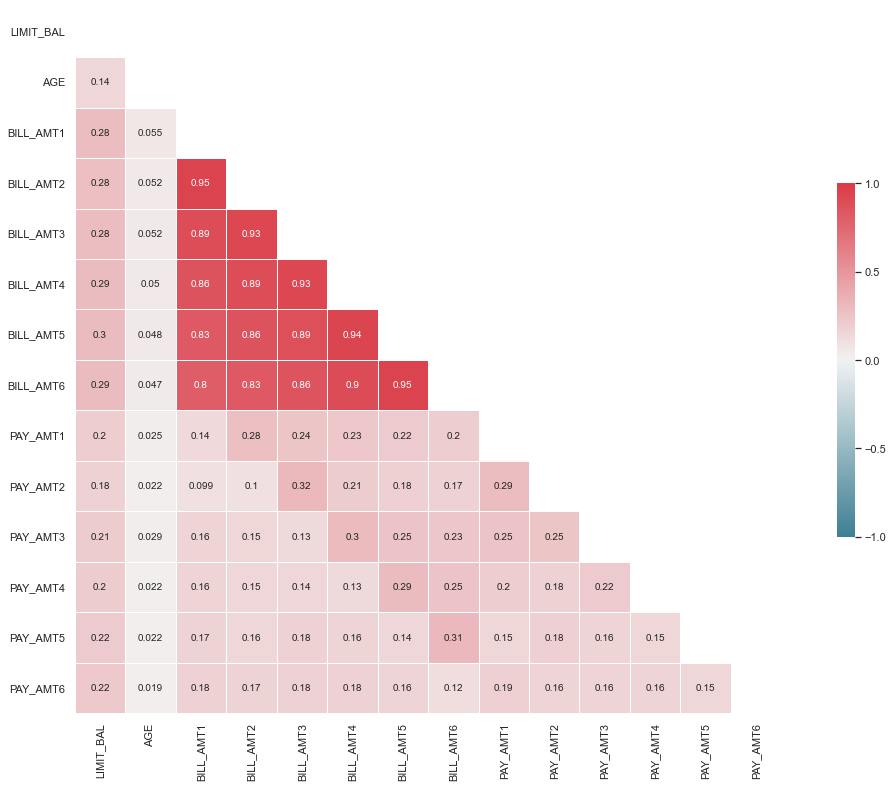

In [28]:
# Correlation matrix
sns.set(style="white", font_scale=1)
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
corr = data[numeric].corr() # .corr is used to find corelation

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cmap=cmap, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 10})
cbar=ax.collections[0].colorbar
cbar.set_ticks([-1, -0.50, 0, 0.50, 1])
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=10)
# plt.show()
plt.savefig('Fig - Correlation matrix by means of the Pearson’s coefficient for all feature pairs.png')

<AxesSubplot:>

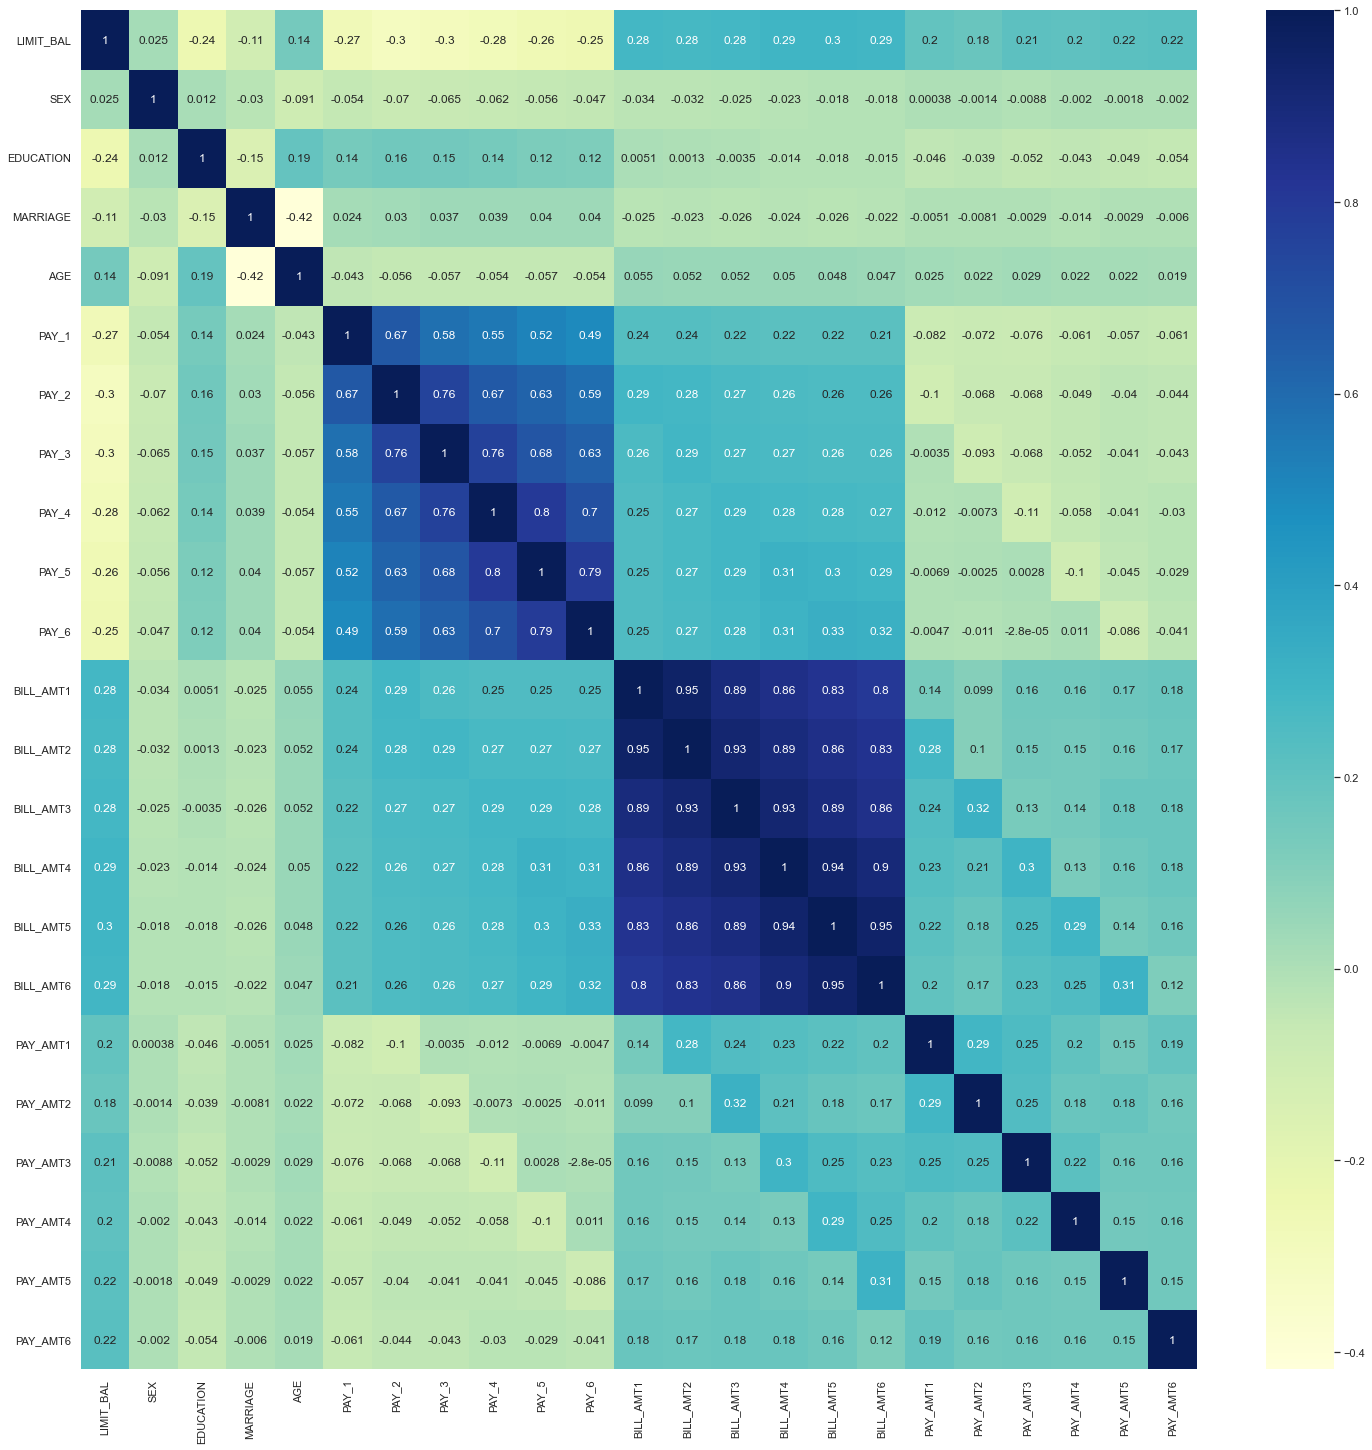

In [29]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", ax = ax)

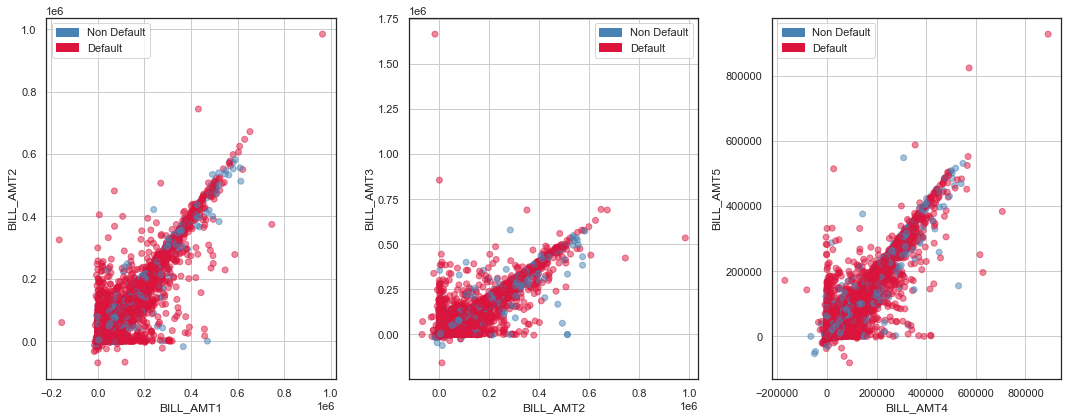

In [30]:
#distribution correlated features -- scatter interaction
import matplotlib.patches as mpatches


data_np=data.to_numpy()
target=data.Default

# variables to 
BILL_AMT1 = data['BILL_AMT1'].to_numpy()
BILL_AMT2 = data['BILL_AMT2'].to_numpy()
BILL_AMT3 = data['BILL_AMT3'].to_numpy()
BILL_AMT4 = data['BILL_AMT4'].to_numpy()
BILL_AMT5 = data['BILL_AMT5'].to_numpy()
BILL_AMT6 = data['BILL_AMT6'].to_numpy()
AGE = data['AGE'].to_numpy()
LIMIT_BAL = data['LIMIT_BAL'].to_numpy()
PAY_AMT1 = data['PAY_AMT1'].to_numpy()

fig, ax = plt.subplots(1,3, figsize= (15,6))

labels=["Non Default","Default"]
pop_a = mpatches.Patch(color='steelblue', label='Non Default')
pop_b = mpatches.Patch(color='crimson', label='Default')
colors=['crimson', 'steelblue']

ax[0].scatter(BILL_AMT1, BILL_AMT2, c=target, cmap=matplotlib.colors.ListedColormap(colors), label=labels, alpha=0.5)
ax[0].grid()
ax[0].set_xlabel('BILL_AMT1')
ax[0].set_ylabel('BILL_AMT2')
ax[0].legend(handles= [pop_a,pop_b])

ax[1].scatter(BILL_AMT2, BILL_AMT3, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[1].grid()
ax[1].set_xlabel('BILL_AMT2')
ax[1].set_ylabel('BILL_AMT3')
ax[1].legend(handles= [pop_a,pop_b])

ax[2].scatter(BILL_AMT4,BILL_AMT5, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[2].grid()
ax[2].set_xlabel('BILL_AMT4')
ax[2].set_ylabel('BILL_AMT5')
ax[2].legend(handles= [pop_a,pop_b])

plt.tight_layout()# let's make good plots
plt.show()

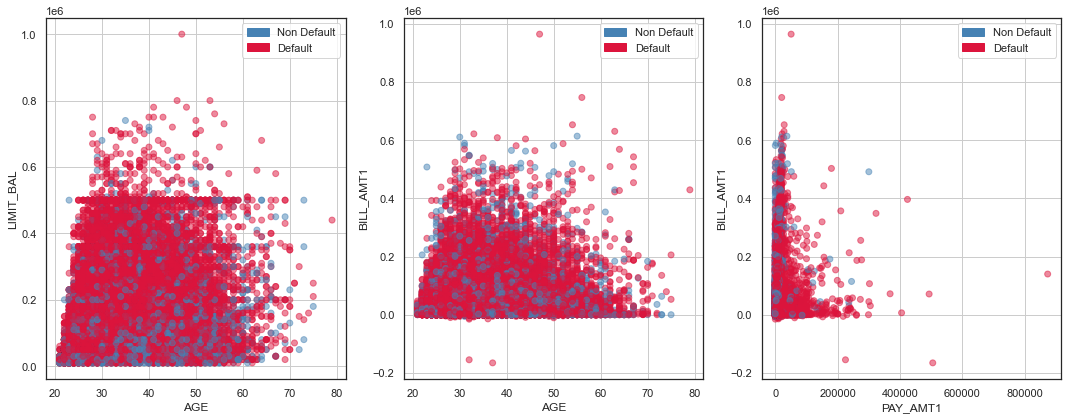

In [31]:
#distribution un-correlated features -- scatter interaction

fig, ax = plt.subplots(1,3, figsize= (15,6))

labels=["Non Default","Default"]
pop_a = mpatches.Patch(color='steelblue', label='Non Default')
pop_b = mpatches.Patch(color='crimson', label='Default')
colors=['crimson', 'steelblue']

ax[0].scatter(AGE, LIMIT_BAL, c=target, cmap=matplotlib.colors.ListedColormap(colors), label=labels, alpha=0.5)
ax[0].grid()
ax[0].set_xlabel('AGE')
ax[0].set_ylabel('LIMIT_BAL')
ax[0].legend(handles= [pop_a,pop_b])

ax[1].scatter(AGE, BILL_AMT1, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[1].grid()
ax[1].set_xlabel('AGE')
ax[1].set_ylabel('BILL_AMT1')
ax[1].legend(handles= [pop_a,pop_b])

ax[2].scatter(PAY_AMT1,BILL_AMT1, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[2].grid()
ax[2].set_xlabel('PAY_AMT1')
ax[2].set_ylabel('BILL_AMT1')
ax[2].legend(handles= [pop_a,pop_b])

plt.tight_layout()# let's make good plots
plt.show()

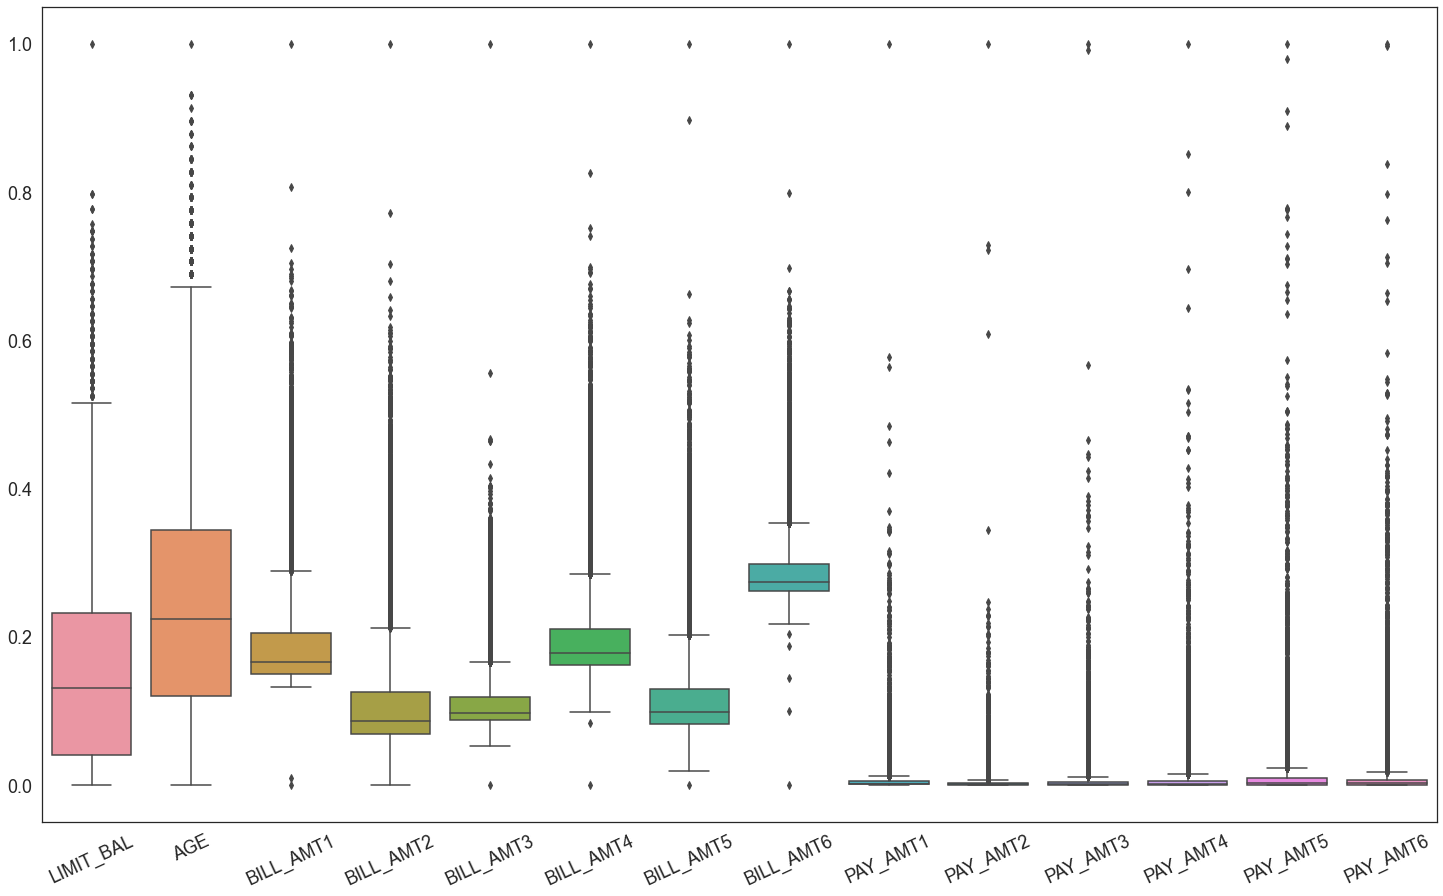

In [32]:
scaler = MinMaxScaler()
data['LIMIT_BAL'] = scaler.fit_transform(data['LIMIT_BAL'].values.reshape(-1, 1))
data['AGE'] = scaler.fit_transform(data['AGE'].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    data['PAY_' + str(i)] = scaler.fit_transform(data['PAY_' + str(i)].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    data['BILL_AMT' + str(i)] = scaler.fit_transform(data['BILL_AMT' + str(i)].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    data['PAY_AMT' + str(i)] = scaler.fit_transform(data['PAY_AMT' + str(i)].values.reshape(-1, 1))
    
# BOXPLOT
cols = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

fig=plt.figure(1, figsize=(25,15))
ax=fig.add_subplot(111)
sns.boxplot(data=data[cols])
plt.xticks(np.arange(0,14), labels=cols, rotation=25, fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Boxplot', fontsize= 35)

plt.savefig('Fig - Boxplot')

#### Standardization

Another possible scaling technique is referred to as **standardization**, which transforms each value $x$ of feature $X$ as follows, independently for each column:

\begin{equation}
x^{\prime} =\frac{x-\mu _{X}}{\sigma _{X}}
\end{equation}

where $\mu_{X}$ is the sample mean and $\sigma_{X}$ is the sample standard deviation of feature $X$. This way, we force each attribute to have a new empirical mean value of 0 and variance 1.


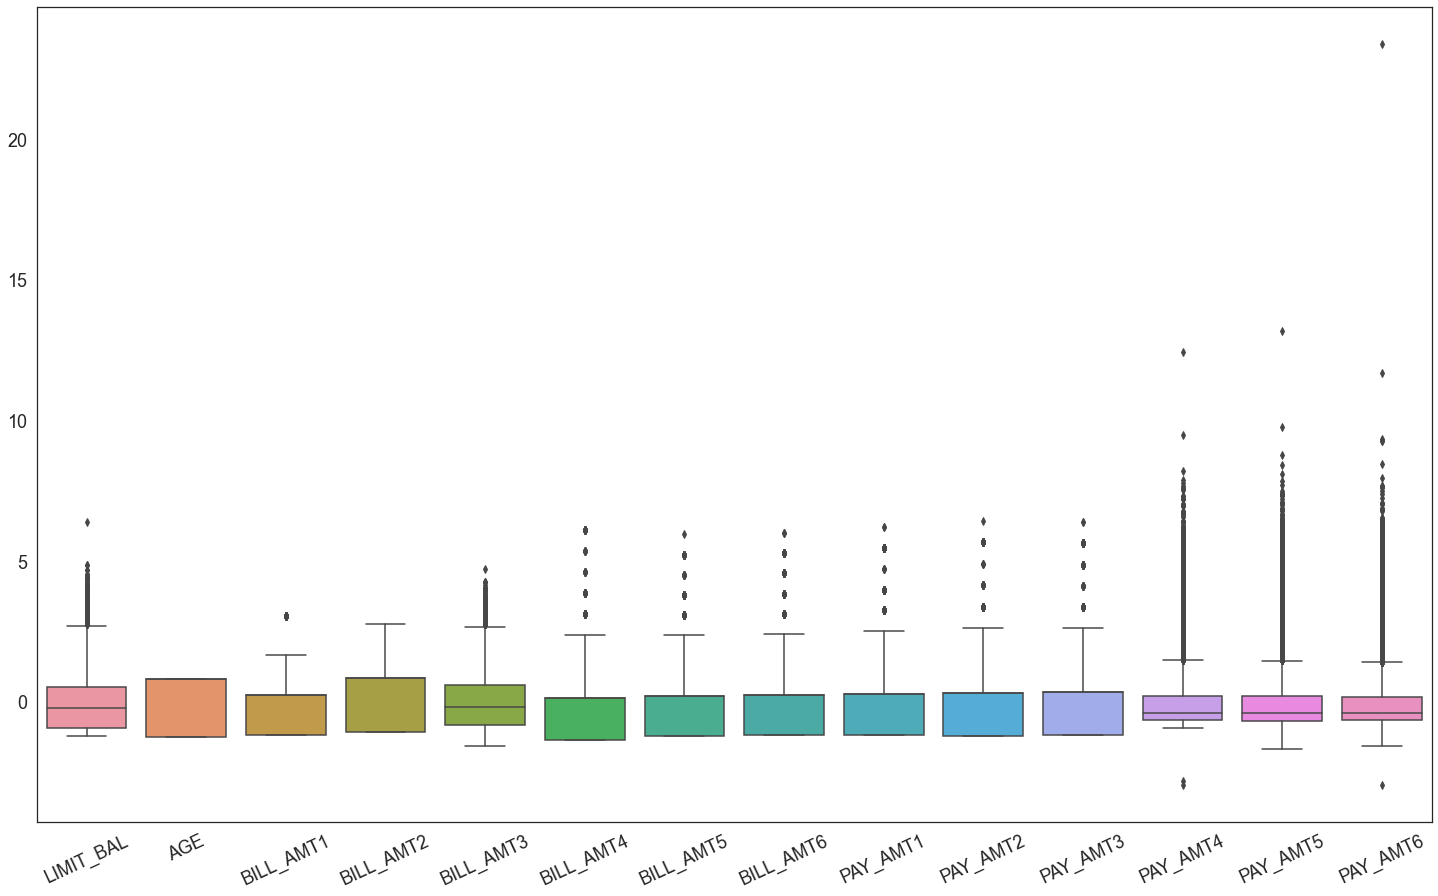

In [33]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# BOXPLOT
cols = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

fig=plt.figure(1, figsize=(25,15))
ax=fig.add_subplot(111)
sns.boxplot(data=scaled_data[:,:-10])
plt.xticks(np.arange(0,14), labels=cols, rotation=25, fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Boxplot', fontsize= 35)

plt.savefig('Fig - Boxplot Std Scaler')

([<matplotlib.axis.XTick at 0x2d152a1e9a0>,
 [Text(1, 0, 'Male'), Text(2, 0, 'Female')])

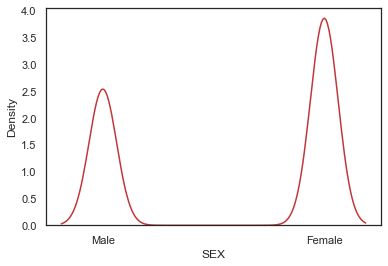

In [34]:
sns.set_palette("RdBu")
positions = (1, 2)
label = ("Male", "Female")
sns.kdeplot(x = 'SEX', data = data)
plt.xticks(positions, label)

([<matplotlib.axis.XTick at 0x2d152a95d30>,
 [Text(1, 0, 'graduate school'),
  Text(2, 0, 'university'),
  Text(3, 0, 'high school'),
  Text(4, 0, 'others')])

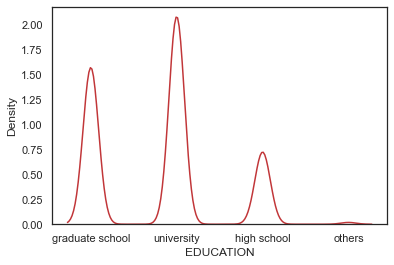

In [35]:
sns.set_palette("RdBu")
def rep(Edu):
  if Edu in [0,4,5,6]:
    return 4
  else:
    return Edu  

data['EDUCATION'] = data['EDUCATION'].apply(rep)     
positions = (1,2,3,4)
labels = ("graduate school", "university", 'high school', 'others')
sns.kdeplot(x='EDUCATION', data= data)
plt.xticks(positions, labels)

([<matplotlib.axis.XTick at 0x2d15353d430>,
 [Text(0, 0, 'others'),
  Text(1, 0, 'married'),
  Text(2, 0, 'single'),
  Text(3, 0, 'divorce')])

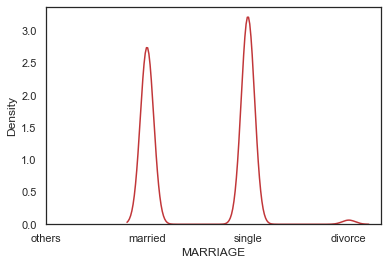

In [36]:
sns.set_palette("RdBu")
positions = (0, 1, 2, 3)
labels = ('others', 'married', 'single', 'divorce')
sns.kdeplot(x = 'MARRIAGE', data = data)
plt.xticks(positions,labels)

<AxesSubplot:xlabel='AGE', ylabel='Density'>

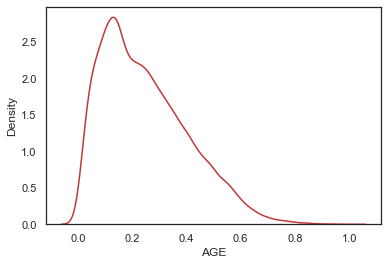

In [37]:
sns.set_palette("RdBu")
sns.kdeplot(x='AGE', data= data)

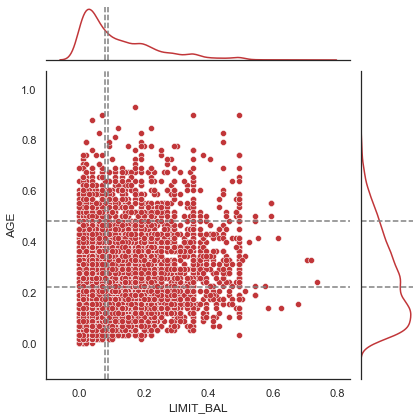

In [38]:
g = sns.JointGrid(data = data[data['Default'] == 1], x = "LIMIT_BAL", y = "AGE")
g.plot(sns.scatterplot, sns.kdeplot)
g.refline(x = 0.09, y = 0.48)
g.refline(x = 0.08, y = 0.22)

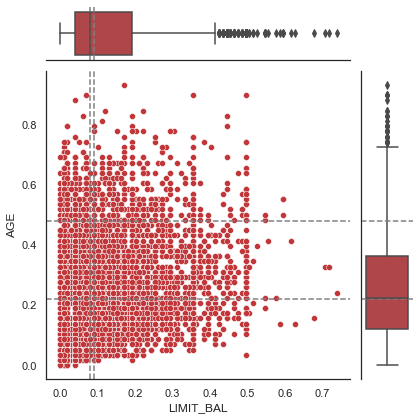

In [39]:
g = sns.JointGrid(data = data[data['Default'] == 1], x = "LIMIT_BAL", y = "AGE")
g.plot(sns.scatterplot, sns.boxplot)
g.refline(x = 0.09, y = 0.48)
g.refline(x = 0.08, y = 0.22)

In [40]:
labeled = data.copy()
labeled['MARRIAGE'] = labeled['MARRIAGE'].replace([0,1,2,3],['others','married','single','divorce'])
labeled['EDUCATION'] = labeled['EDUCATION'].replace([1,2,3,4],['graduate school', 'university' , 'high school','others'])
labeled['SEX'] = labeled['SEX'].replace([1,2],["Male", "Female"])

<AxesSubplot:xlabel='SEX,MARRIAGE,EDUCATION'>

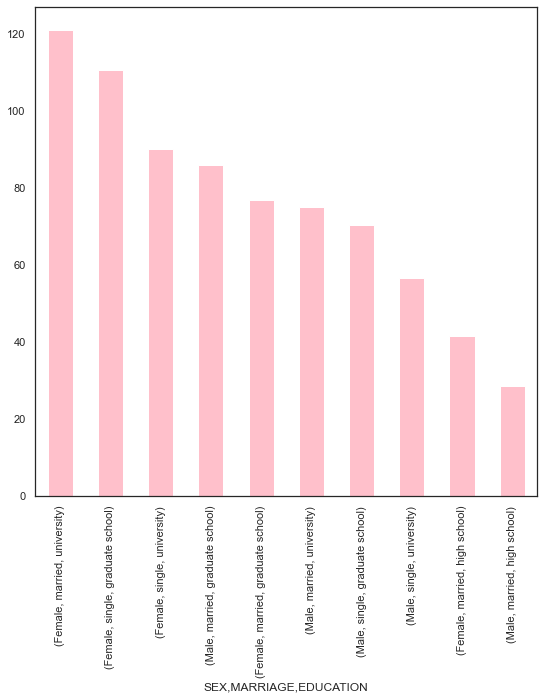

In [41]:
labeled[labeled['Default']==1].groupby(['SEX','MARRIAGE','EDUCATION'])['LIMIT_BAL'].sum().sort_values(ascending=False)[0:10].plot(kind = "bar",figsize=(9,9),color='pink')

<AxesSubplot:xlabel='SEX,MARRIAGE,EDUCATION'>

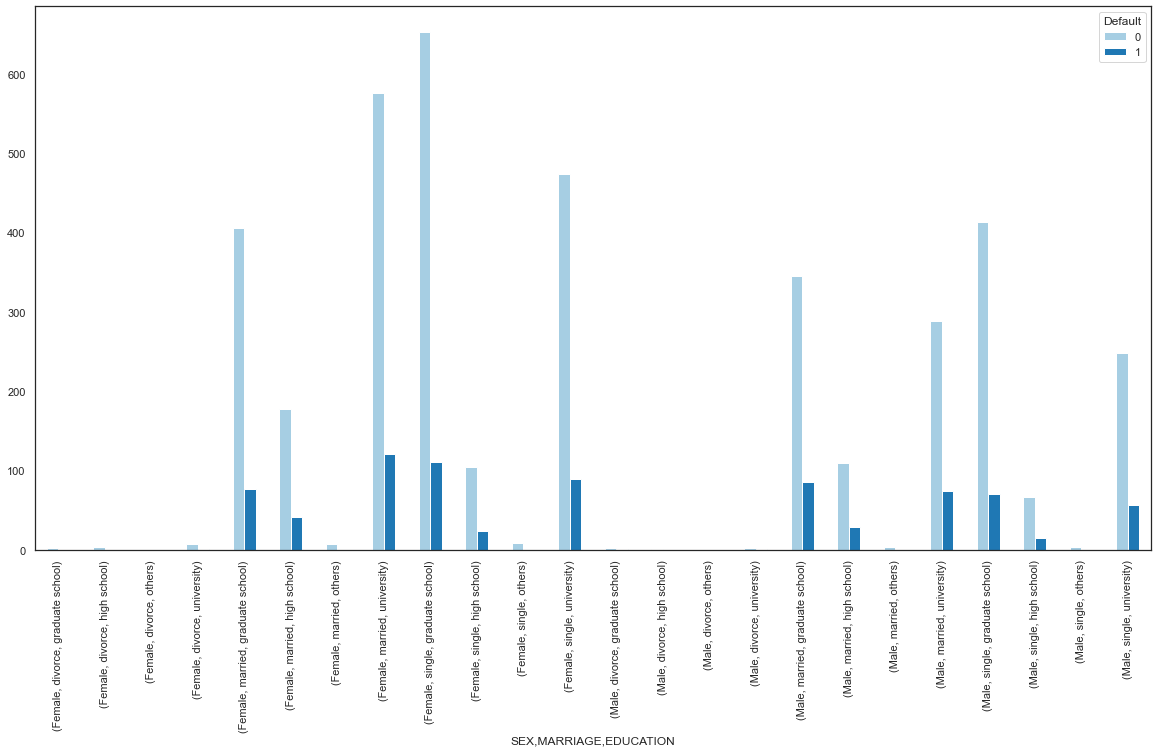

In [42]:
sns.set_palette('Paired')
labeled.groupby(['SEX','MARRIAGE','EDUCATION', 'Default'])['LIMIT_BAL'].sum().sort_values(ascending=False).unstack().plot(kind = "bar" , figsize=(20,10))

<AxesSubplot:xlabel='SEX,MARRIAGE,EDUCATION'>

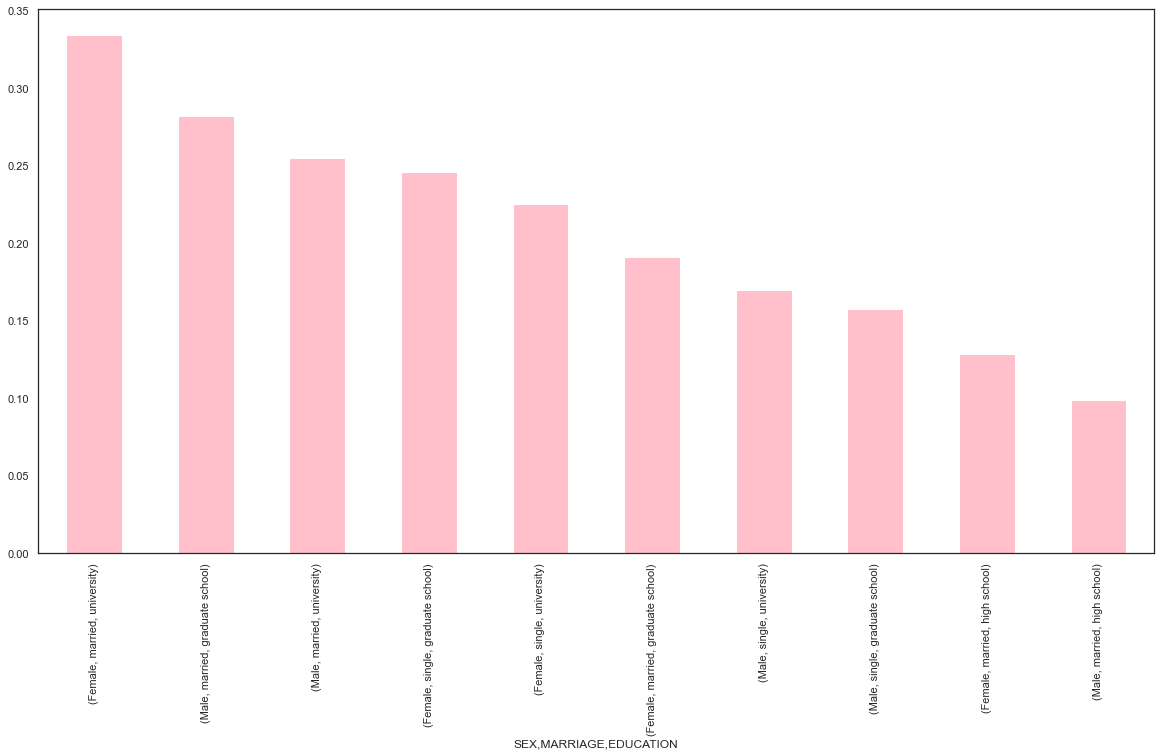

In [43]:
sns.set_palette("tab10")
ratio = labeled.groupby(['SEX', 'MARRIAGE', 'EDUCATION', 'Default'])['LIMIT_BAL'].sum().sort_values(ascending=False).unstack()
ratio = ratio.replace(np.NaN,0)

ratio[1] = (ratio[1]-ratio[1].min())/(ratio[1].max()-ratio[1].min())

ratio['ratio_dpnm']=ratio[1]/ratio[0]

ratio['ratio_dpnm'] = (ratio['ratio_dpnm']-ratio['ratio_dpnm'].min())/(ratio['ratio_dpnm'].max()-ratio['ratio_dpnm'].min())

ratio['ratio'] = ratio['ratio_dpnm']*ratio[1]
ratio['ratio'].sort_values(ascending=False)[0:10].plot(kind='bar' , figsize=(20,10),color='pink')

In [44]:
# Set 'category' type to categorical attributes
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  data[att] = data[att].astype('category')

# one-hot encoding
data=pd.concat([pd.get_dummies(data['SEX'], prefix='SEX'),
                pd.get_dummies(data['EDUCATION'], prefix='EDUCATION'), 
                pd.get_dummies(data['MARRIAGE'], prefix='MARRIAGE'),
                data],axis=1)
# drop original columns
data.drop(['EDUCATION'],axis=1, inplace=True)
data.drop(['SEX'],axis=1, inplace=True)
data.drop(['MARRIAGE'],axis=1, inplace=True)
# print samples
data.head()

,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,0,1,0,1,0,0,1,0,0,0.01,...,0.16,0.08,0.26,0.00e+00,4.09e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1
1,0,1,0,1,0,0,0,1,0,0.11,...,0.16,0.08,0.26,0.00e+00,5.94e-04,1.12e-03,1.61e-03,0.00e+00,3.78e-03,1
2,0,1,0,1,0,0,0,1,0,0.08,...,0.17,0.10,0.27,1.74e-03,8.91e-04,1.12e-03,1.61e-03,2.34e-03,9.46e-03,0
3,0,1,0,1,0,0,1,0,0,0.04,...,0.19,0.11,0.28,2.29e-03,1.20e-03,1.34e-03,1.77e-03,2.51e-03,1.89e-03,0
4,1,0,0,1,0,0,1,0,0,0.04,...,0.18,0.10,0.28,2.29e-03,2.18e-02,1.12e-02,1.45e-02,1.62e-03,1.28e-03,0


In [45]:
# Separating features and target
y = data.Default     # target default=1 or non-default=0
X = data.drop('Default', axis = 1, inplace = False)

In [46]:
# Check data set dimension
print(X.shape)
print("Number of samples:", X.shape[0])
print("Number of attributes:", X.shape[1])

(29601, 29)
Number of samples: 29601
Number of attributes: 29


In [47]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

In [48]:
# Check dimensions
print(np.shape(X_train_val))
print(np.shape(X_test))

print("Training set:")
print(f" + Non-defaulters (y=0): {len(y_train_val[y_train_val==0])}")
print(f" + Defaulters (y=1):\t {len(y_train_val[y_train_val==1])}")

print("Test set:")
print(f" + Non-defaulters (y=0): {len(y_test[y_test==0])}")
print(f" + Defaulters (y=1):\t {len(y_test[y_test==1])}")

(22200, 29)
(7401, 29)
Training set:
 + Non-defaulters (y=0): 17246
 + Defaulters (y=1):	 4954
Test set:
 + Non-defaulters (y=0): 5750
 + Defaulters (y=1):	 1651


In [49]:
if FEATURE_SELECTION :
    # remove features with correlation coefficent >= 0.93
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.92)]
    print(to_drop) #['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    data= data.drop(data[to_drop], axis = 1)

Actual number of components: 29


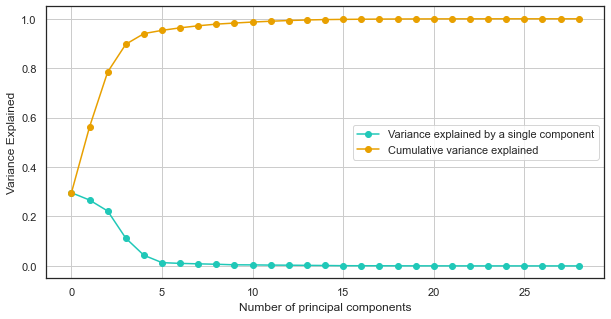

In [50]:
from sklearn.decomposition import PCA

print(f"Actual number of components: {len(X_train_val.columns.values)}")

n_pc = len(X_train_val.columns.values) # with n_components = 11 -> 0.98693009 variance explained

pca = PCA(n_components=n_pc)
pca.fit(X_train_val)

# print(np.cumsum(pca.explained_variance_ratio_))
# print(pca.explained_variance_ratio_)

fig=plt.figure(1, figsize=(10,5))
plt.grid(b=True, which='major', axis='both')
plt.plot(pca.explained_variance_ratio_, marker='o', color='#20c8b8')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='#e8a000')
# plt.xticks([n for n in range(0,n_pc)], [ "PC"+str(n) for n in range(1,n_pc+1)])
plt.legend(["Variance explained by a single component", "Cumulative variance explained"])
plt.xlabel('Number of principal components')
plt.ylabel('Variance Explained')
plt.savefig("PCA");

In [51]:
n_pc = 12
pca = PCA(n_components=n_pc)
pca.fit(X_train_val)
#   X_train_val.index = pd.RangeIndex(start=0, stop=len(X_train_val), step=1)
X_12d_train_val = pd.DataFrame(pca.transform(X_train_val))
X_12d_test = pd.DataFrame(pca.transform(X_test))
X_12d_train_val.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]
X_12d_test.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]
X_12d_train_val.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,1.15,0.53,0.42,-0.20,0.05,-0.06,-0.03,8.00e-03,-1.02e-01,-0.12,0.13,-9.53e-03
1,0.17,-0.67,-0.82,-0.04,0.04,0.37,-0.10,4.24e-02,-4.01e-03,-0.07,-0.01,-8.76e-03
2,-0.87,-0.29,0.56,0.85,-0.28,-0.02,-0.27,1.47e-01,2.03e-01,-0.08,-0.11,-2.49e-02
3,-0.52,-0.38,0.93,-0.31,0.71,-0.10,0.09,-7.04e-02,2.04e-02,-0.09,-0.05,3.32e-03
4,-1.07,-0.25,-0.30,-0.23,0.24,0.39,-0.03,-9.61e-03,3.43e-02,-0.20,0.11,-1.48e-04


In [52]:
APPLY_PCA = False

if APPLY_PCA: 
    X_train_val = X_12d_train_val
    X_test = X_12d_test
    print(X_12d_train_val.shape)
    print(X_12d_test.shape)
    
print(f"PCA APPLIED: {APPLY_PCA}")
print(X_train_val.shape)
print(X_test.shape)

PCA APPLIED: False
(22200, 29)
(7401, 29)


In [53]:
import imblearn 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import make_pipeline

import sklearn.ensemble
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# PARAMETER CLASSIFICATION
ALGORITHM = 'LogisticRegression' # 'RandomForest', 'LogisticRegression', 'LDA', 'KNN'
APPLY_OVERSAMPLING = False
APPLY_UNDERSAMPLING = True

if APPLY_OVERSAMPLING:
    APPLY_UNDERSAMPLING = False
    
if APPLY_UNDERSAMPLING:
    APPLY_OVERSAMPLING = False

In [ ]:
# TRAIN AND VALIDATION
# Stratified K-Fold Cross Validation

# Pipeline
if ALGORITHM == 'SVM' : 
    # Support Vector Machine (SVM) classifier
    # best config found {'C': 1, 'gamma': 0.01, 'kernel': 'poly'} # 0.7963817277250114
    parameter_grid = {
      'C': [100, 0.1, 1, 10],
      'kernel': ['rbf', 'poly'],
      'gamma': [0.0001, 0.001, 0.01]
    }
    clf_name = 'svc__'
    classifier = SVC() # or SVC
    
elif ALGORITHM == 'RandomForest':
    # Random Forest classifier
    # {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__oob_score': True}
    parameter_grid = {
      "criterion":["gini", "entropy"],
      "max_features":[None, "sqrt"],
      "oob_score":[True],
      "n_estimators":[10, 50, 100, 200]
    }
    clf_name = 'randomforestclassifier__'
    classifier = RandomForestClassifier()
    
elif ALGORITHM == 'LogisticRegression':
    # Logistic Regression classifier
    parameter_grid = {
        "C":[0.0001, 0.001, 0.01, 0.1, 1, 10]
    }
    clf_name = 'logisticregression__'
    classifier = LogisticRegression()
    
elif ALGORITHM == 'KNN':
    # K-Nearest Neighbors classifier
    parameter_grid = {
        "n_neighbors":[500, 800, 1500, 2500, 3500, 4500]
    }
    clf_name = 'kneighborsclassifier__'
    classifier = KNeighborsClassifier() 
else :
    raise RuntimeError("Choose a correct classifier.");
    

new_params = {clf_name + key: parameter_grid[key] for key in parameter_grid}

kfold = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

if APPLY_OVERSAMPLING:
    
    imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), classifier)
elif APPLY_UNDERSAMPLING:
    # TO DO
    imba_pipeline = make_pipeline(ClusterCentroids(random_state=RANDOM_STATE), classifier)
else :
    # DO NOT apply oversampling on training dataset, just the classifier
    imba_pipeline = make_pipeline(classifier)

SCORE = 'precision' # 'accuracy', 'precision', 'recall', 'f1'
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kfold, scoring=SCORE, return_train_score=True)

grid_imba.fit(X_train_val, y_train_val)

print(f"Best configuration found for {classifier}:")
print(grid_imba.best_params_)
print(f"Val {SCORE}:{grid_imba.best_score_}")

In [ ]:
# TEST
# evaluation on test data with bestparams

# Oversampling
smote = SMOTE()
X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)

# retrain with best params
clf = classifier
clf.fit(X_train_val, y_train_val)
y_pred = clf.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)

print(accuracy, f1, precision, recall)
print(f"")

# print(classification_report())

disp = plot_confusion_matrix(clf, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues, 
                                 #display_labels=data.target_names, 
                                 normalize='true')

disp.ax_.set_title(f'normalized confusion matrix {clf_name}')